In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
folder = '/dlabdata1/lugeon/datasets/'
#folder = '../data/'
name = 'websites_dmoz_multi'
ext = '.gz'
data = pd.read_csv(folder + name + ext, header=0)

In [6]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
data.head()

,uid,url,lang,lang_id,cat0
0,184,www.delphipraxis.net,Deutsch,de,Computers
1,263,www.central-it.de,Deutsch,de,Computers
2,731,www.aus-wandern.de,Deutsch,de,Computers
3,1072,blog.cvjm-nuernberg.de,Deutsch,de,Computers
4,1101,www.ges-training.de,Deutsch,de,Computers


In [8]:
data.cat0.nunique() # number of categories

13

In [9]:
def is_homepage(link):
    return not('/' in link) or (link.count('/') == 1 and link.endswith('/'))

In [10]:
is_hp = data.url.apply(is_homepage)
is_hp.value_counts()

True    1025181
Name: url, dtype: int64

In [11]:
data.shape[0] 

1025181

In [12]:
df_en = data[data.lang_id == 'en'][['uid', 'url', 'cat0']]
df_en.cat0.value_counts(), df_en.shape

(Business      148144
 Society        82079
 Arts           66721
 Shopping       54062
 Recreation     46095
 Computers      45194
 Sports         34890
 Science        28138
 Health         24218
 Reference      21663
 Games          10246
 Home            6952
 News            3696
 Name: cat0, dtype: int64,
 (572098, 3))

In [13]:
df_red = pd.DataFrame([])

samples_per_cat = 10_000

for cat in df_en.cat0.unique():
        df_cat = df_en[df_en.cat0 == cat]
        n_samples = min(samples_per_cat, df_cat.shape[0])
        df_cat = df_cat.sample(n_samples, random_state=42)
        df_red = pd.concat((df_red, df_cat))

In [14]:
df_red.cat0.value_counts()

Recreation    10000
Games         10000
Computers     10000
Sports        10000
Health        10000
Society       10000
Shopping      10000
Science       10000
Arts          10000
Business      10000
Reference     10000
Home           6952
News           3696
Name: cat0, dtype: int64

In [15]:
test_size = 2000
df_test = df_red.groupby('cat0').sample(test_size, random_state=42)

def in_test(uid):
    return not(uid in df_test.uid.values)

train_mask = df_red.uid.apply(in_test)
df_train = df_red[train_mask]

In [16]:
df_test.shape, df_train.shape

((26000, 3), (94648, 3))

In [17]:
df_test.head()

,uid,url,cat0
721336,1173390,www.mfaust.de,Arts
996475,2364463,www.johnheinrich.net,Arts
1024437,2484946,writersliving.com,Arts
846520,1709909,www.polemusic.net,Arts
636138,800354,www.buddhabellystudio.com,Arts


In [83]:
df_train.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_en_full_train.gz', compression='gzip')
df_test.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_en_full_valid.gz', compression='gzip')

## Multilingual 

In [18]:
data.lang.unique()

array(['Deutsch', 'Français', 'Russian', 'Español', 'Türkçe', 'Japanese',
       'Português', 'Chinese_Simplified', 'Italiano', 'English'],
      dtype=object)

In [19]:
data.groupby('lang').uid.count().sort_values(ascending=False)

lang
English               572098
Deutsch               182911
Japanese               64500
Français               58271
Russian                44348
Italiano               43425
Türkçe                 21199
Español                19833
Chinese_Simplified     14481
Português               4115
Name: uid, dtype: int64

In [20]:
langs = ['English', 'Deutsch', 'Français', 'Italiano']

In [21]:
df_multi = data[data.lang.apply(lambda x: x in langs)]

In [22]:
df_multi.groupby(['lang', 'cat0']).uid.count().sort_values()[:10]

lang      cat0     
Italiano  News          367
Français  News          531
Italiano  Home          751
          Reference    1173
          Games        1207
          Science      1296
          Computers    1303
          Health       1428
Français  Home         1628
Deutsch   News         1684
Name: uid, dtype: int64

In [23]:
df_lang_balanced = pd.DataFrame([])

categories = df_multi.cat0.unique()

for cat in categories:
    df_cat = df_multi[df_multi.cat0 == cat]
    min_samples = df_cat.groupby('lang').uid.count().min()
    for lang in langs:
        df_cat_lang = df_cat[df_cat.lang == lang]
        nsamples = df_cat_lang.shape[0]
        df_cat_lang = df_cat_lang.sample(min(nsamples, 1 * min_samples), random_state=42)
        df_lang_balanced = pd.concat((df_lang_balanced, df_cat_lang))

In [24]:
df_lang_balanced.groupby('cat0').uid.count().sort_values()

cat0
News           1468
Home           3004
Reference      4692
Games          4828
Science        5184
Computers      5212
Health         5712
Sports         8344
Shopping       9880
Recreation    10060
Society       17568
Arts          25292
Business      35736
Name: uid, dtype: int64

In [25]:
df_lang_balanced = df_lang_balanced[['uid', 'url', 'cat0', 'lang']]

In [26]:
df_lang_balanced.shape

(136980, 4)

In [19]:
df_lang_balanced.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_lang.gz', compression='gzip')

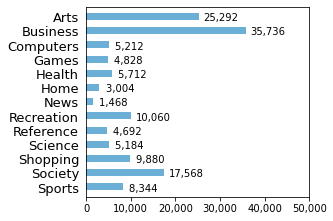

In [122]:
fig, ax = plt.subplots(figsize=(4,3.5))

cmap = plt.cm.get_cmap('tab20c')
color1 = cmap(1)

height=0.5

cat_count = df_lang_balanced.groupby('cat0').uid.count()

values = cat_count.values


labels = cat_count.index.values
y = np.arange(len(labels))


rects = ax.barh(y=y, width=values, height=height, color=color1)

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=13)

ax.set_xticks([0, 10_000, 20_000, 30_000, 40_000, 50_000])
ax.set_xticklabels(["0", "10,000", "20,000", "30,000", "40,000", "50,000"], fontsize=10)

#plt.xscale('log')

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=True) # labels along the bottom edge are off

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False,      # ticks along the bottom edge are off
    labeltop=False,
    bottom=True,
    labelbottom=True) # labels along the bottom edge are off


ax.set_ylim([-1 + 0.3, len(labels) - 0.3])

ax.invert_yaxis() 

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:<6,}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(22, -6),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

autolabel(rects)

#ax.vlines([10_000, 20_000, 30_000], ymin=-1, ymax=13, linestyles='dotted', colors='black', linewidths=1)

plt.savefig('nb_samples_experiment.png', bbox_inches='tight')

plt.show()

## English samples for the visual model

In [112]:
df_lang_balanced

,uid,url,cat0,lang
934747,2094851,www.gyrosystem.co.uk,Computers,English
888399,1892699,www.capegraphics.com,Computers,English
610948,691456,jsutils.sourceforge.net,Computers,English
514655,267211,www.gwei.org,Computers,English
596136,624824,www.simplewire.com,Computers,English
...,...,...,...,...
452403,250787,www.laretedellemamme.it,Home,Italiano
452438,369156,www.spaziomutui.com,Home,Italiano
452602,865101,www.prodotti-per-capelli.it,Home,Italiano
452767,1436606,www.infanziaweb.it,Home,Italiano


In [113]:
mask = df_en.uid.apply(lambda x: x in df_lang_balanced.uid.values)

In [114]:
df_visual = df_en[~mask]

In [115]:
df_visual.cat0.value_counts(), df_visual.shape

(Business      139210
 Society        77687
 Arts           60398
 Shopping       51592
 Computers      43891
 Recreation     43580
 Sports         32804
 Science        26842
 Health         22790
 Reference      20490
 Games           9039
 Home            6201
 News            3329
 Name: cat0, dtype: int64,
 (537853, 3))

In [116]:
max_n_samples = 20_000

df_visual = df_visual.groupby('cat0').apply(lambda c: c.sample(min(max_n_samples, c.uid.count()), random_state=42))

df_visual.index = np.arange(df_visual.shape[0])

In [117]:
df_visual.cat0.value_counts()

Recreation    20000
Computers     20000
Shopping      20000
Arts          20000
Sports        20000
Health        20000
Society       20000
Science       20000
Business      20000
Reference     20000
Games          9039
Home           6201
News           3329
Name: cat0, dtype: int64

In [118]:
df_visual

,uid,url,cat0
0,802185,www.rvbulck.com,Arts
1,1627438,www.littleredhot.bizland.com,Arts
2,1468320,www.kinema.uwaterloo.ca,Arts
3,2019775,www.cops.com,Arts
4,1462539,www.mindness.net,Arts
...,...,...,...
218564,258754,northeastkarate.com,Sports
218565,2204926,www.premieregolfsolutions.com,Sports
218566,1856386,www.hudsonvalleylacrosse.com,Sports
218567,2175584,www.mantiskungfu.bravepages.com,Sports


In [119]:
df_visual_valid = df_visual.groupby('cat0').sample(frac=0.2, random_state=42)

mask = df_visual.uid.apply(lambda x: x in df_visual_valid.uid.values)

df_visual_train = df_visual[~mask]


In [144]:
df_visual_valid.cat0.value_counts()

Sports        4000
Reference     4000
Recreation    4000
Shopping      4000
Science       4000
Society       4000
Health        4000
Business      4000
Arts          4000
Computers     4000
Games         1808
Home          1240
News           666
Name: cat0, dtype: int64

In [145]:
df_visual_train.cat0.value_counts()

Science       16000
Sports        16000
Reference     16000
Society       16000
Arts          16000
Health        16000
Computers     16000
Recreation    16000
Shopping      16000
Business      16000
Games          7231
Home           4961
News           2663
Name: cat0, dtype: int64

In [146]:
df_visual_train.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_visual_train.gz', compression='gzip')
df_visual_valid.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_visual_valid.gz', compression='gzip')

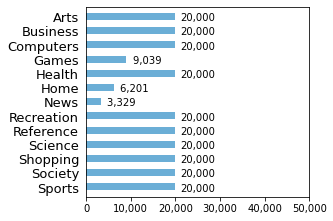

In [121]:
fig, ax = plt.subplots(figsize=(4,3.5))

cmap = plt.cm.get_cmap('tab20c')
color1 = cmap(1)

height=0.5

cat_count = df_visual.groupby('cat0').uid.count()

values = cat_count.values


labels = cat_count.index.values
y = np.arange(len(labels))


rects = ax.barh(y=y, width=values, height=height, color=color1)

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=13)

ax.set_xticks([0, 10_000, 20_000, 30_000, 40_000, 50_000])
ax.set_xticklabels(["0", "10,000", "20,000", "30,000", "40,000", "50,000"], fontsize=10)

#plt.xscale('log')

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=True) # labels along the bottom edge are off

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top=False,      # ticks along the bottom edge are off
    labeltop=False,
    bottom=True,
    labelbottom=True) # labels along the bottom edge are off


ax.set_ylim([-1 + 0.3, len(labels) - 0.3])

ax.invert_yaxis() 

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:<6,}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(22, -6),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

autolabel(rects)

#ax.vlines([10_000, 20_000, 30_000], ymin=-1, ymax=13, linestyles='dotted', colors='black', linewidths=1)

plt.savefig('nb_samples_visual.png', bbox_inches='tight')

plt.show()

## Multi langual visual set

In [40]:
mask = df_multi.uid.apply(lambda x: x in df_lang_balanced.uid.values)

In [41]:
df_visual_lang = df_multi[~mask]

In [42]:
df_visual_lang.cat0.value_counts()

Business      183910
Society        95478
Arts           80114
Recreation     63001
Shopping       61975
Computers      58269
Sports         48865
Health         44037
Science        34598
Reference      24685
Games          11904
Home            8079
News            4810
Name: cat0, dtype: int64

In [43]:
df_visual_lang.head(1)

,uid,url,lang,lang_id,cat0
0,184,www.delphipraxis.net,Deutsch,de,Computers


In [44]:
df_visual_lang.groupby(['cat0', 'lang']).uid.count().sort_values()[:10]

cat0       lang    
Sports     Italiano     111
News       Français     164
Shopping   Italiano     172
Games      Français     802
Home       Français     877
           Deutsch     1001
News       Deutsch     1317
Reference  Français    1558
Games      Deutsch     2063
Health     Français    2626
Name: uid, dtype: int64

In [45]:
df_visual_lang.lang.value_counts()

English     537853
Deutsch     148666
Français     24026
Italiano      9180
Name: lang, dtype: int64

In [46]:
df_visual_lang_ = pd.DataFrame()

for l in df_visual_lang.lang.unique():
    df_l = df_visual_lang[df_visual_lang.lang == l]
    max_samples = df_l.shape[0]
    df_l = df_l.sample(min(max_samples, 80_000), random_state=42)
    df_visual_lang_ = pd.concat((df_visual_lang_, df_l))
    

In [47]:
df_visual_lang_.shape

(193206, 5)

In [48]:
df_visual_lang_.lang.value_counts()

English     80000
Deutsch     80000
Français    24026
Italiano     9180
Name: lang, dtype: int64

In [49]:
df_visual_lang_.cat0.value_counts()

Business      48672
Society       22616
Arts          21913
Recreation    18818
Health        16100
Computers     15668
Sports        13569
Shopping      13383
Science        9555
Reference      6004
Games          3269
Home           2275
News           1364
Name: cat0, dtype: int64

In [50]:
df_visual_lang_valid = df_visual_lang_.groupby('cat0').sample(frac=0.2, random_state=42)

mask = df_visual_lang_.uid.apply(lambda x: x in df_visual_lang_valid.uid.values)

df_visual_lang_train = df_visual_lang_[~mask]

In [51]:
df_visual_lang_valid.shape, df_visual_lang_train.shape

((38643, 5), (154563, 5))

In [55]:
df_visual_lang_train[['uid', 'url', 'cat0']].to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_visual_lang_train.gz', compression='gzip')
df_visual_lang_valid[['uid', 'url', 'cat0']].to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_visual_lang_valid.gz', compression='gzip')

## Japanese testing set

In [56]:
df_jap = data[data.lang_id == 'ja']

In [57]:
df_jap.cat0.value_counts()

Business      28969
Arts           9471
Society        5417
Sports         4302
Shopping       4095
Recreation     2751
Health         2556
Science        1649
Reference      1202
Computers      1175
Games          1092
News            954
Home            867
Name: cat0, dtype: int64

In [58]:
df_jap = df_jap.groupby('cat0').sample(800, random_state=42)

In [59]:
df_jap.head(5)

,uid,url,lang,lang_id,cat0
362897,205759,www.kinder.co.jp,Japanese,ja,Arts
366748,1207394,www.hdc-dance.jp,Japanese,ja,Arts
368337,1629800,hayashiyasometa.ec-net.jp,Japanese,ja,Arts
368588,1695107,www.makken.com,Japanese,ja,Arts
364485,607658,www.tmaa.jp,Japanese,ja,Arts


In [123]:
df_jap = df_jap[['uid', 'url', 'cat0']]

In [124]:
df_jap.shape

(10400, 3)

In [127]:
df_jap.to_csv('/dlabdata1/lugeon/dmozfinalset/dmoz_jap.gz', compression='gzip')

In [128]:
df_jap

,uid,url,cat0
362897,205759,www.kinder.co.jp,Arts
366748,1207394,www.hdc-dance.jp,Arts
368337,1629800,hayashiyasometa.ec-net.jp,Arts
368588,1695107,www.makken.com,Arts
364485,607658,www.tmaa.jp,Arts
...,...,...,...
386797,1719542,www.jkf-hs.com,Sports
385366,885747,www.beckham.jp,Sports
387281,1992841,www.tara.or.jp,Sports
385792,1151055,www.jbsa.jp,Sports
